# Regression Model for Survey Data

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor

from sklearn import metrics
np.random.seed(42)

In [2]:
# Read Data
df = pd.read_csv('../../data/survey.csv')

# From Rick's cleaning
df.rename(columns = {'family_history_with_overweight':'fam_hx_overweight', 
                     'MTRANS':'transport',
                     'FAVC':'high_cal_foods',
                     'FCVC':'vegetables',
                     'NCP':'main_meals',
                     'CAEC': 'food_bw_meals',
                     'SMOKE': 'smoke',
                     'CH2O': 'H2O',
                     'SCC': 'monitor_cals',
                     'FAF': 'physical_activity',
                     'TUE': 'tech_use',
                     'CALC': 'alcohol',
                     'NObeyesdad': 'obesity'}, 
          inplace = True)

# Binarize columns
df['fam_hx_overweight'] = df['fam_hx_overweight'].map({'yes':1, 'no':0})
df['high_cal_foods'] = df['high_cal_foods'].map({'yes':1, 'no':0})
df['smoke'] = df['smoke'].map({'yes':1, 'no':0})
df['monitor_cals'] = df['monitor_cals'].map({'yes':1, 'no':0})

# Get dummies
df = pd.get_dummies(data = df, columns = ['Gender', 'food_bw_meals', 'alcohol', 'transport'], drop_first = True)

# Create polynomial features
poly = PolynomialFeatures(2, interaction_only = True, include_bias = False)
array_poly = poly.fit_transform(df[['Height', 'high_cal_foods', 'vegetables', 'main_meals', 'H2O']])

# Polynomial Feature Dataframe
df_poly = pd.DataFrame(array_poly, columns = poly.get_feature_names_out(['Height', 'high_cal_foods', 'vegetables', 'main_meals', 'H2O']))

# Merge Polynomial Features df
df = df.merge(df_poly.iloc[:,4:], left_index = True, right_index = True)

# Create height^2 column
df['h2'] = df['Height'] ** 2

X = df.drop(columns = ['obesity', 'Weight'])
y = df['Weight']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [3]:
# Pipelines function
def pipe_model(model):
    pipe = Pipeline([
        ('ss', StandardScaler()),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)
    print(f'{model}')
    print(f'Training r2 score: {pipe.score(X_train, y_train)}')
    print(f'Testing r2 score: {pipe.score(X_test, y_test)}')
    print(f'Testing MSE: {metrics.mean_squared_error(y_test, pipe.predict(X_test))}')
    return print('='*40)

In [4]:
pipe_model(LinearRegression())
pipe_model(KNeighborsRegressor())
pipe_model(DecisionTreeRegressor())
pipe_model(BaggingRegressor())
pipe_model(RandomForestRegressor())
pipe_model(AdaBoostRegressor())

LinearRegression()
Training r2 score: 0.5909953407191537
Testing r2 score: 0.5799892184442049
Testing MSE: 297.23932533910914
KNeighborsRegressor()
Training r2 score: 0.8984835144637466
Testing r2 score: 0.8121469030470617
Testing MSE: 132.94260588816837
DecisionTreeRegressor()
Training r2 score: 1.0
Testing r2 score: 0.7601561101642688
Testing MSE: 169.7362047169495
BaggingRegressor()
Training r2 score: 0.9809798405367192
Testing r2 score: 0.8620851068104951
Testing MSE: 97.60161311577676
RandomForestRegressor()
Training r2 score: 0.9861900089207774
Testing r2 score: 0.8607558668542279
Testing MSE: 98.54230893875335
AdaBoostRegressor()
Training r2 score: 0.7212455735351814
Testing r2 score: 0.6666124366699029
Testing MSE: 235.93654913718802


In [5]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

rf = RandomForestRegressor()
rf.fit(X_train_sc, y_train)
rf.feature_importances_

array([7.94130313e-02, 2.22422638e-02, 2.50622310e-01, 2.17284073e-04,
       4.60638660e-03, 1.78615943e-02, 3.32543186e-04, 2.73328722e-03,
       1.29133622e-03, 5.27584933e-02, 1.77854595e-02, 7.27382911e-02,
       5.03831088e-03, 2.96612355e-02, 1.07339767e-04, 7.60877629e-04,
       6.31757387e-02, 4.10062115e-03, 3.86663570e-05, 5.45610906e-05,
       1.69441515e-02, 4.77717380e-04, 3.10199172e-03, 9.21906089e-02,
       5.89625169e-02, 2.34168539e-02, 1.10294496e-02, 5.84742168e-02,
       1.80641225e-02, 4.42974414e-03, 4.71410836e-02, 6.59414311e-03,
       9.42736999e-03, 2.42063985e-02])

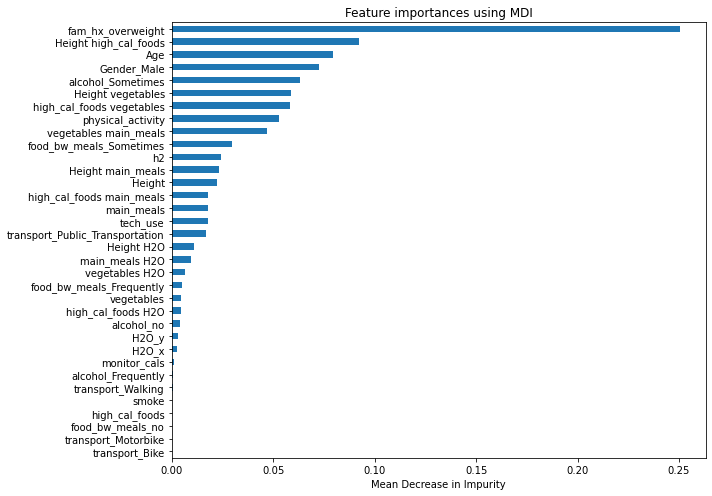

In [6]:
# From sklearn https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
feature_names = X.columns
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=feature_names).sort_values()

fig, ax = plt.subplots(figsize = (10,7))
forest_importances.plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean Decrease in Impurity")
fig.tight_layout()
plt.savefig('../../images/rfr_feat_importances.png');

In [7]:
# Baseline MSE
metrics.mean_squared_error(y_test, pd.Series(y.mean(), index=range(len(y_test))))

707.6969768635811